In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta
import itertools


RANDOM_STATE=42

# Загрузка и первичный анализ данных

In [2]:
# Загружаем оба листа из Excel-файла
file_path = "/kaggle/input/gpb-adm-data/gpb_adm_data.xlsx"
xls = pd.ExcelFile(file_path)

# Считываем листы
tids_df = xls.parse("TIDS")
incomes_df = xls.parse("Incomes")

# Просматриваем размеры и первые строки
tids_info = tids_df.info()
incomes_info = incomes_df.info()
tids_preview = tids_df.head()
incomes_preview = incomes_df.iloc[:, :6]  # первые 5 дат и TID

tids_df.shape, incomes_df.shape, tids_preview, incomes_preview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TID        1630 non-null   int64  
 1   longitude  1630 non-null   float64
 2   latitude   1630 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 38.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   TID                  1630 non-null   int64
 1   2022-09-01 00:00:00  1630 non-null   int64
 2   2022-09-02 00:00:00  1630 non-null   int64
 3   2022-09-03 00:00:00  1630 non-null   int64
 4   2022-09-04 00:00:00  1630 non-null   int64
 5   2022-09-05 00:00:00  1630 non-null   int64
 6   2022-09-06 00:00:00  1630 non-null   int64
 7   2022-09-07 00:00:00  1630 non-null   int64
 8   2022-09-08 00:00:00  1630 non-null   int64
 9   202

((1630, 3),
 (1630, 92),
       TID  longitude   latitude
 0  692835  37.646257  55.742062
 1  698656  37.666136  55.731231
 2  686168  37.675027  55.727031
 3  679671  37.669706  55.706824
 4  682180  37.596399  55.711151,
          TID  2022-09-01 00:00:00  2022-09-02 00:00:00  2022-09-03 00:00:00  \
 0     406136                90000               105000                99000   
 1     406139               103000               206000               168000   
 2     406145               143000               136000               124000   
 3     406148                50000                73000                53000   
 4     406180                96000                82000                71000   
 ...      ...                  ...                  ...                  ...   
 1625  699578                    0                    0                10000   
 1626  699579                49000                68000                    0   
 1627  699629                63000                63000 

In [3]:
# Преобразуем таблицу Incomes в длинный формат
incomes_long = pd.melt(incomes_df, id_vars="TID", var_name="date", value_name="income")

# Преобразуем колонку date в формат datetime
incomes_long["date"] = pd.to_datetime(incomes_long["date"])

# Объединяем с таблицей TIDS по колонке TID
incomes_full = pd.merge(incomes_long, tids_df, on="TID", how="left")

# Проверим результат
incomes_full.info(), incomes_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148330 entries, 0 to 148329
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TID        148330 non-null  int64         
 1   date       148330 non-null  datetime64[ns]
 2   income     148330 non-null  int64         
 3   longitude  148330 non-null  float64       
 4   latitude   148330 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 5.7 MB


(None,
       TID       date  income  longitude   latitude
 0  406136 2022-09-01   90000  38.034618  55.641764
 1  406139 2022-09-01  103000  37.932528  55.701643
 2  406145 2022-09-01  143000  37.609267  55.596382
 3  406148 2022-09-01   50000  37.477741  55.892675
 4  406180 2022-09-01   96000  37.656786  55.707940)

Отлично. Мы получили объединённую таблицу **incomes_full** в длинном формате:

Размер: `148 330` строк — это `1630` АДМ × `91` день.

Колонки:

- **TID**: идентификатор терминала,
- **date**: дата внесения,
- **incom**e: сумма внесений в рублях,
- **longitude** и **latitude**: геолокация АДМ.

Теперь мы можем начать EDA

# Исследовательский анализ данных

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


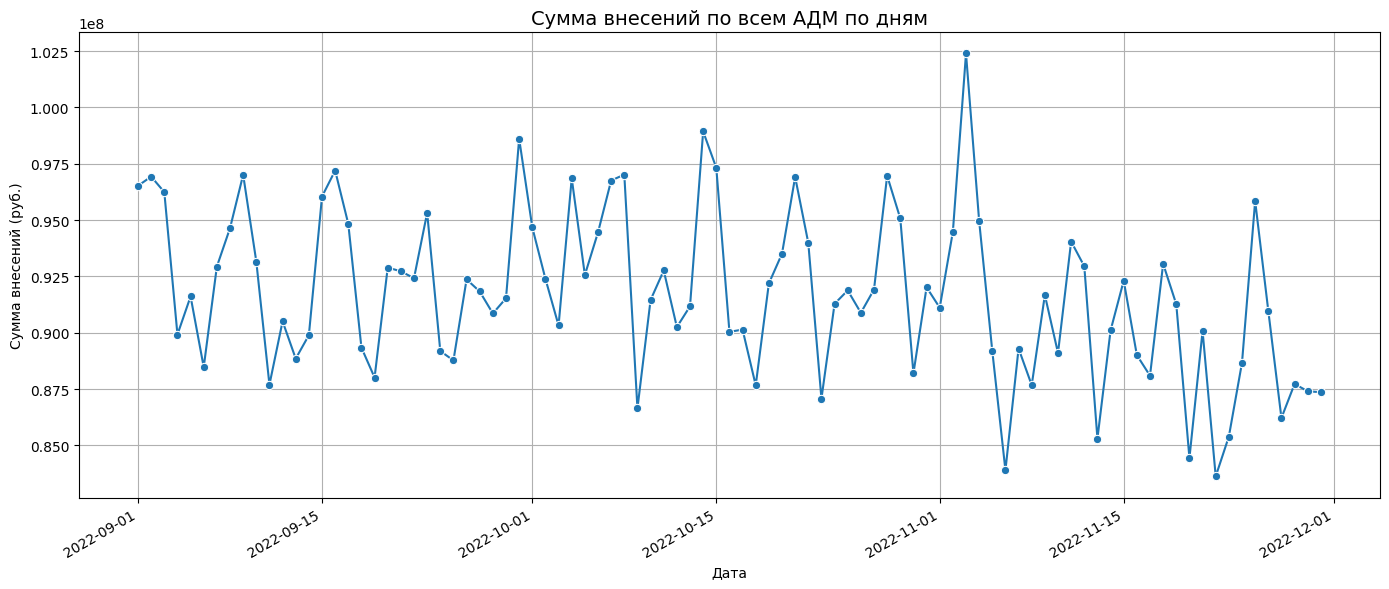

In [4]:
# Группируем по дате и считаем сумму внесений по всем АДМ и строим график
daily_income = incomes_full.groupby("date")["income"].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=daily_income, x="date", y="income", marker="o", ax=ax)
ax.set_title("Сумма внесений по всем АДМ по дням", fontsize=14)
ax.set_xlabel("Дата")
ax.set_ylabel("Сумма внесений (руб.)")
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

График  построен — он наглядно показывает суточные суммы внесений во все АДМ:

Чётко видно циклическое поведение (недели).

Отмечаются периодические пики — возможно, выплаты или сезонные факторы.

Присутствует умеренная волатильность.

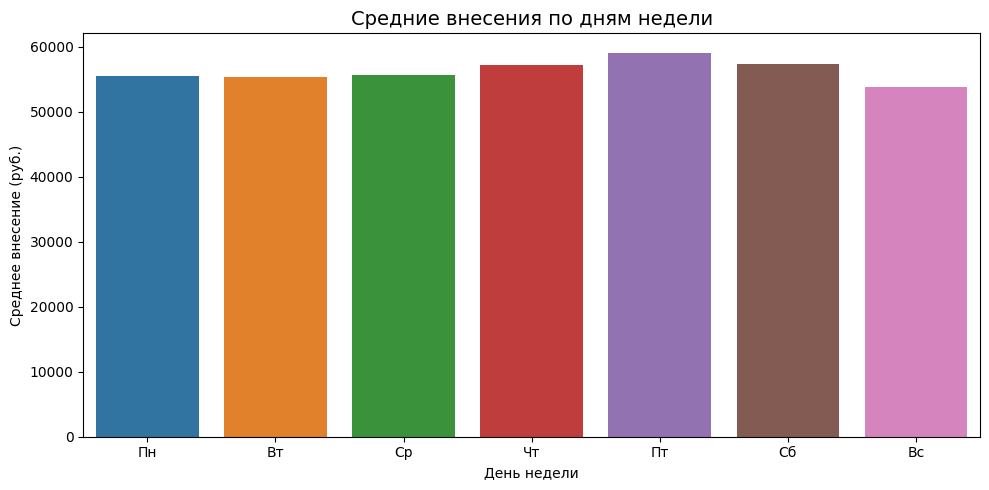

In [5]:
# Добавим дня недели
incomes_full["weekday"] = incomes_full["date"].dt.dayofweek
weekday_income = incomes_full.groupby("weekday")["income"].mean().reset_index()
weekday_map = {0: "Пн", 1: "Вт", 2: "Ср", 3: "Чт", 4: "Пт", 5: "Сб", 6: "Вс"}
weekday_income["weekday_name"] = weekday_income["weekday"].map(weekday_map)

# Визуализируем
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=weekday_income, x="weekday_name", y="income", ax=ax)
ax.set_title("Средние внесения по дням недели", fontsize=14)
ax.set_xlabel("День недели")
ax.set_ylabel("Среднее внесение (руб.)")
plt.tight_layout()
plt.show()

Максимальные внесения приходятся на будние дни — особенно вторник, среда и пятница.

Минимальные суммы — в субботу и воскресенье, что типично для юр.лиц в отличае от физиков.

Это подтверждает цикличность по дням недели.



Далее посмотрим распределение активности по АДМ и кластеризируем терминалы по поведенческим паттернам (внесениям).

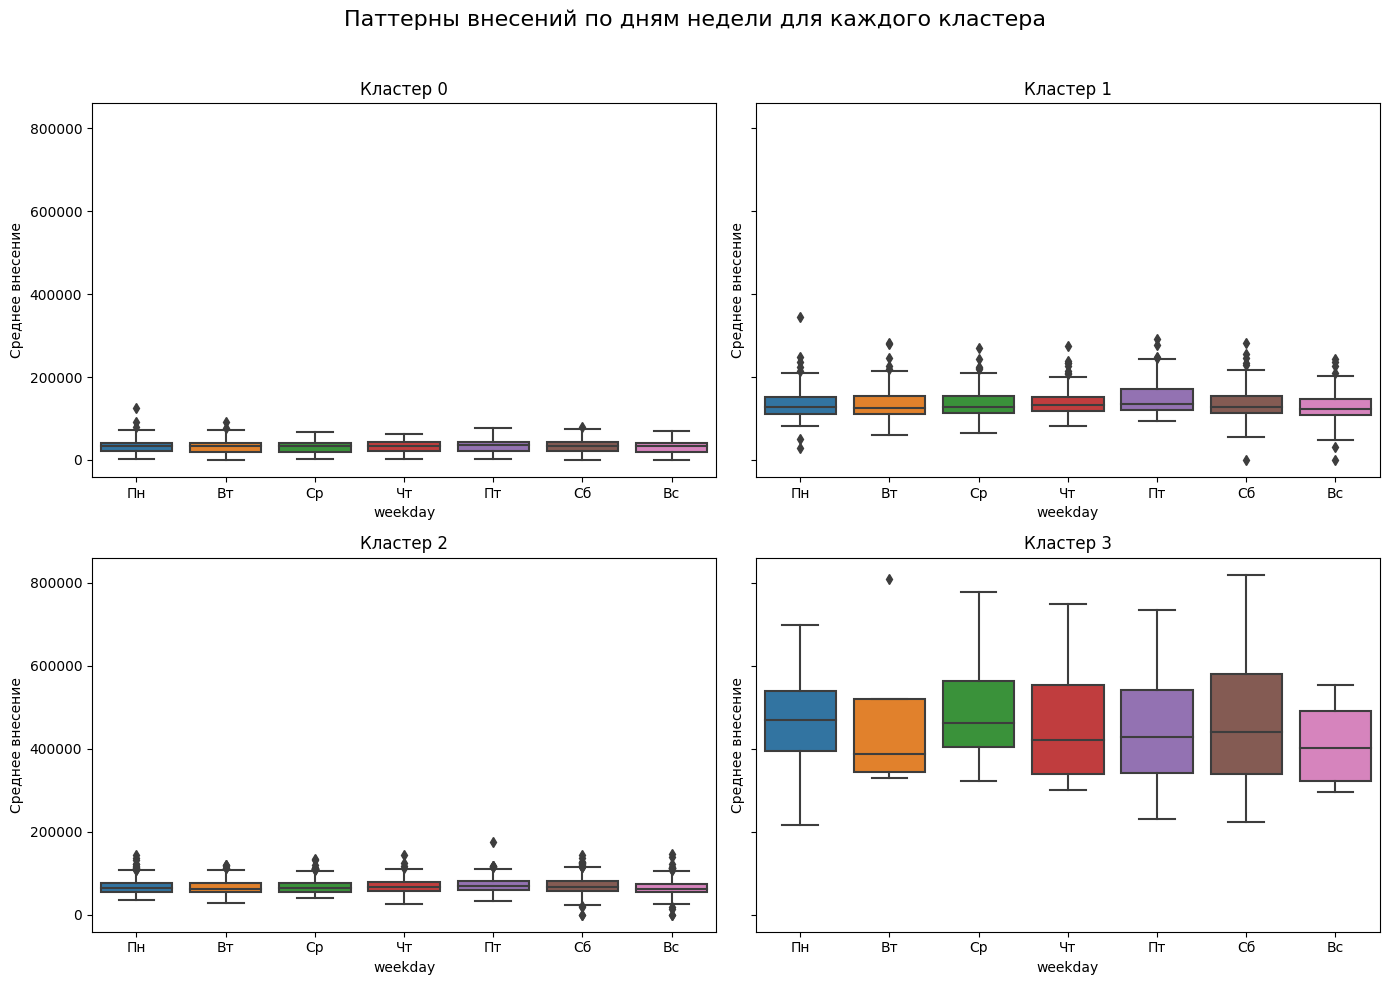

In [6]:
# Сумма по АДМ
adm_total = incomes_full.groupby("TID")["income"].sum().reset_index()

# Средние внесения по дням недели для каждого АДМ
weekly_pattern = incomes_full.groupby(["TID", "weekday"])["income"].mean().unstack().fillna(0)

# Нормализация
scaler = StandardScaler()
weekly_scaled = scaler.fit_transform(weekly_pattern)

# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(weekly_scaled)

# Добавление кластеров
weekly_pattern["cluster"] = clusters
adm_total = adm_total.merge(weekly_pattern["cluster"], on="TID")

# Визуализация кластеров

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
days = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
for i in range(4):
    cluster_data = weekly_pattern[weekly_pattern["cluster"] == i].iloc[:, :7]
    sns.boxplot(data=cluster_data, ax=axes[i // 2][i % 2])
    axes[i // 2][i % 2].set_title(f"Кластер {i}")
    axes[i // 2][i % 2].set_xticklabels(days)
    axes[i // 2][i % 2].set_ylabel("Среднее внесение")

plt.suptitle("Паттерны внесений по дням недели для каждого кластера", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Кластеры по паттернам активности получились следующими:

- **Кластер 0**: равномерная активность в будни, сниженная по выходным — стандартное поведение ЦА.

- **Кластер 1**: пик в начале недели, особенно в понедельник.

- **Кластер 2**: слабая и нерегулярная активность — возможно, терминалы в удалённых районах или временно неиспользуемые.

- **Кластер 3**: активность ближе к пятнице — может быть связано с зарплатными днями или целевыми платежами.


# Построение признаков

Будем делать **time-series features** на уровне каждого АДМ:

Добавим:
- Лаги: 1, 3, 7 дней.
- Скользящие средние: 3, 7, 14 дней.
- День недели (one-hot / категориально).
- Выходной или будний (через pandas.tseries.holiday или просто weekday ≥ 5).
- Кластер терминала (уже есть).
- Геолокация (широта/долгота).
- Кол-во дней до конца месяца.

In [7]:
# Копируем датафрейм для построения признаков
df = incomes_full.copy()

# Сортируем данные
df = df.sort_values(["TID", "date"])

# Лаги и скользящие средние
for lag in [1, 3, 7]:
    df[f"lag_{lag}"] = df.groupby("TID")["income"].shift(lag)

for window in [3, 7, 14]:
    df[f"roll_mean_{window}"] = df.groupby("TID")["income"].shift(1).rolling(window=window).mean().reset_index(0, drop=True)

# День недели и выходной
df["weekday"] = df["date"].dt.dayofweek
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

# День месяца / конец месяца
df["day"] = df["date"].dt.day
df["days_to_month_end"] = df["date"].dt.days_in_month - df["date"].dt.day

# Добавим кластер
df = df.merge(adm_total[["TID", "cluster"]], on="TID", how="left")

# Удалим строки с NaN в новых признаках (из-за лагов и скользящих)
df = df.dropna().reset_index(drop=True)

df.head()


,TID,date,income,longitude,latitude,weekday,lag_1,lag_3,lag_7,roll_mean_3,roll_mean_7,roll_mean_14,is_weekend,day,days_to_month_end,cluster
0,406136,2022-09-08,89000,38.034618,55.641764,3,75000.0,110000.0,90000.0,7666.666667,8857.142857,9000.000000,0,8,22,2
1,406136,2022-09-09,95000,38.034618,55.641764,4,89000.0,60000.0,105000.0,76000.000000,73571.428571,75642.857143,0,9,21,2
2,406136,2022-09-10,116000,38.034618,55.641764,5,95000.0,75000.0,99000.0,33333.333333,36857.142857,39142.857143,1,10,20,2
3,406136,2022-09-13,84000,38.034618,55.641764,1,110000.0,116000.0,60000.0,28000.000000,27428.571429,32714.285714,0,13,17,2
4,406136,2022-09-14,51000,38.034618,55.641764,2,84000.0,85000.0,75000.0,33333.333333,35142.857143,35000.000000,0,14,16,2


5: Разделение данных
Мы делаем time-series split. Можно взять:

train: сентябрь + октябрь;

val: ноябрь;

test: прогнозируем декабрь (в финале).

In [8]:
# Разделим train/val по дате
cutoff_date = pd.to_datetime("2022-11-01")
train_df = df[df["date"] < cutoff_date]
val_df = df[df["date"] >= cutoff_date]

# Целевая переменная
TARGET = "income"
FEATURES = [col for col in df.columns if col not in ["income", "date", "TID"]]


Моделью возьмем **LightGBM**  — градиентный бустинг по деревьям решений, оптимизированный для скорости и эффективности т.к.у него хорошая производительность на табличных данных, он дружит с  временными рядми и числовыми признаками. Лоялен к принимаемым данным. Быстро учистя и предсказыает. Устойчив к переобучению. Есть возможность анализа значимости признаков (чем чуть позже и воспользуемся).

Метрики возьмем **MAE** и **RMSE**

**MAE**- Средняя абсолютная ошибка в рублях. Простая интерпретация для бизнеса. Устойчивость к выбросам.

**RMSE** - Корень из среднеквадратичной ошибки. Жестче штрафует за крупные отклонения. Позволяет выявить аномалии (при сравнении с MAE)

### Почему не другие метрики:
- **MAPE**: проблемы при значениях близких к нулю
- **R²**: сложен для бизнес-интерпретации
- **SHAP**: черезмерно тяжелый и комлпексный на данном этапе

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2116
[LightGBM] [Info] Number of data points in the train set: 74482, number of used features: 13
[LightGBM] [Info] Start training from score 56744.327489
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.43937e+08
[100]	valid_0's l2: 6.40289e+08
Early stopping, best iteration is:
[70]	valid_0's l2: 6.37084e+08


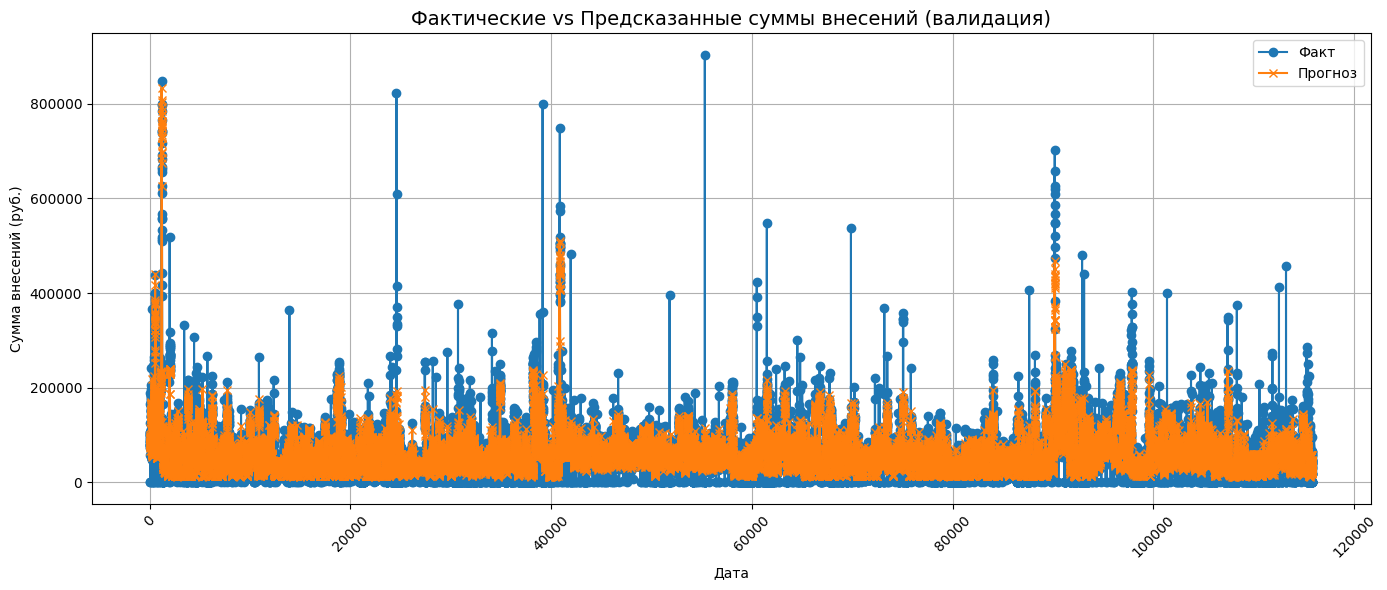

MAE: 13056.20
RMSE: 25240.53


In [9]:
# Данные
train_X = train_df[FEATURES]
train_y = train_df[TARGET]
val_X = val_df[FEATURES]
val_y = val_df[TARGET]

# Модель
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

lgb_model.fit(
    train_X, train_y,
    eval_set=[(val_X, val_y)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# Предсказания
val_preds = lgb_model.predict(val_X)

# Собираем в DataFrame для графика
val_result = val_X.copy()
val_result["true_income"] = val_y
val_result["predicted_income"] = val_preds
val_result["date"] = val_result.index  # если индексы — это даты

# Группируем по дате
val_daily = val_result.groupby("date")[["true_income", "predicted_income"]].sum().reset_index()

# График
plt.figure(figsize=(14, 6))
plt.plot(val_daily["date"], val_daily["true_income"], label="Факт", marker="o")
plt.plot(val_daily["date"], val_daily["predicted_income"], label="Прогноз", marker="x")
plt.title("Фактические vs Предсказанные суммы внесений (валидация)", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Сумма внесений (руб.)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Метрики
mae = mean_absolute_error(val_y, val_preds)
rmse = mean_squared_error(val_y, val_preds, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Метрики вполне разумные для первой модели.

Разберем какие признаки наиболее важны для предсказания.

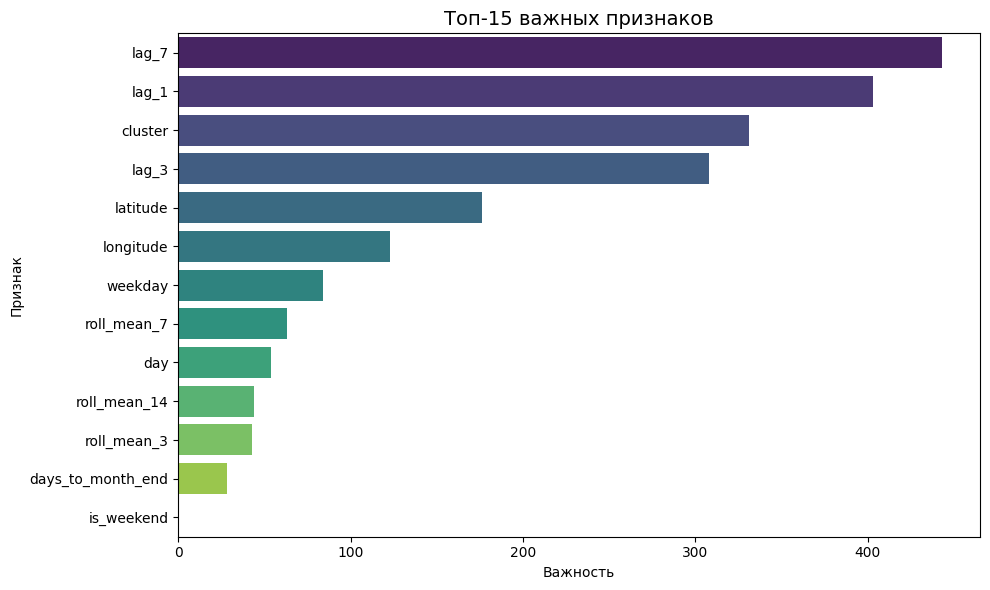

In [10]:
importances = lgb_model.feature_importances_
features = train_X.columns
importance_df = pd.DataFrame({"feature": features, "importance": importances})
importance_df = importance_df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="importance", y="feature", palette="viridis")
plt.title("Топ-15 важных признаков", fontsize=14)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


### **lag**-признаки 
  
     Почему такие лаги и что они дают 
- **lag1** — работает почти как автокорреляция.
- **lag7** — захватывает недельный ритм.  
- **lag3** — отражаеь ритмы "каждые три дня", что дает отрыв от дней недели.  

        Причины:
- Пользователи действуют циклично (например, еженедельные внесения в один день: пенсии, зарплаты).  
- Эти признаки напрямую отражают недавнюю активность и часто сильнее коррелируют с будущими значениями, чем календарные данные.  
       

###  **cluster** 

Признак **cluster** кодирует поведение клиентов, завязанное на время недели.
Он может объяснять разные шаблоны внесений, которые не видны через latitude/longitude, но важны для модели.
Как итог видим поведение по дням недели, закодированное в **cluster**, а не просто на географическое расположение терминала.

Модель использует **cluster** , чтобы понять:

- Насколько вероятен пик внесения в конкретный день недели.
- Какова сезонность по дню недели в этом сегменте.


### Кордитнаты
Идут сразу после lag-признаков, что может означать:  
- **Активные локации** (центр города, вокзалы).  
- **Региональные паттерны** (север/юг, сезонность).  

Можно  преобразовать их через кластеризацию или расстояния до центров активности, создав дополнительную и/или смешанную кластеризацию.  



### Календарные признаки ниже по важности  
**День недели**, **день месяца**, **выходной** влияют, но слабее, чем lag-признаки. 

     Причины: 
- Календарные признаки **грубее**, а лаги — **точные и специфичные**.  
- Пример: не все вносят деньги по пятницам, но вчерашняя сумма почти всегда информативна.  



### Скользящие средние  
Менее важны, чем лаги (особенно `roll_mean 7/14`).  

Вероятно слишком сглалаживается активность, которая "замыливается" на пиках.  



### На подумать. Потенцильные направления для **feature engineering**
- **География:** добавить категории (округ, ТЦ/улица, тип здания).  
- **Праздники:** флаг "праздничный день".
- **Дни полчки:** Промаркивароть основни дни выплат и протестировать различные лаги в том чсиле по привязке к категории точки к оторйо привязан АДМ. 
- **Тренды:** признаки вида "текущая неделя vs средняя".

# Моделирование
Задача - сделать прогноз на весь декабрь

Используем обученную модель

Прогнозируем вперёд на 31 день (1–31 декабря)

Для этого построим датасет, где будут корректно рассчитаны:

- **lag_1**, **lag_3**, **lag_7**

- **roll_mean_3**, **roll_mean_7**, **roll_mean_14**

- все остальные фичи: **weekday**, **is_weekend**, **day**, **days_to_month_end**, **latitude**, **longitude**, **cluster**

  

Lag-признаки и скользящие средние: 'ти признаки требуют исторических данных.

На 1 декабря мы можем использовать фактические значения за конец ноября.

Далее будем накапливать прогнозы, чтобы формировать лаги и скользящие средние на следующие дни.

Календарные признаки (уже легко достроить):

День недели, день месяца, выходной или нет, сколько дней до конца месяца и т.д.

Кластер — остается прежними, 



Создадим DataFrame с датами с 1 по 31 декабря для каждого уникального АДМ (по координатам latitude, longitude).

In [11]:
# Сумма по АДМ
adm_total = incomes_full.groupby("TID")["income"].sum().reset_index()

# Добавление поведенческих кластеров
adm_clusters = weekly_pattern[["cluster"]].reset_index()

# Привязка TID к геокоординатам (предполагается, что TID однозначно определяет lat/lon)
tid_coords = train_df[["TID", "latitude", "longitude"]].drop_duplicates()

# Соединяем кластеры с координатами
adm_clusters = adm_clusters.merge(tid_coords, on="TID", how="left")

# Уникальные точки АДМ
adm_points = train_df[['latitude', 'longitude']].drop_duplicates()

# Даты декабря
december_dates = pd.date_range('2022-12-01', '2022-12-31')

# Каркас декабрьских данных
future = pd.DataFrame([
    {'latitude': lat, 'longitude': lon, 'date': date}
    for lat, lon in adm_points.values
    for date in december_dates
])

# Календарные признаки
future['weekday'] = future['date'].dt.weekday
future['day'] = future['date'].dt.day
future['days_to_month_end'] = future['date'].dt.days_in_month - future['day']
future['is_weekend'] = future['weekday'].isin([5, 6]).astype(int)

# Исторические данные до конца ноября
history = pd.concat([train_df, val_result], ignore_index=True)
history['date'] = pd.to_datetime(history['date'])
history = history[history['date'] <= '2022-11-30'].copy()

# Приводим название таргета к единому виду
if 'income' in history.columns and 'true_income' not in history.columns:
    history['true_income'] = history['income']

# Объединяем историю и декабрь
df_full = pd.concat([
    history[['latitude', 'longitude', 'date', 'true_income']],
    future.assign(true_income=np.nan)
], ignore_index=True, sort=False)

df_full = df_full.sort_values(['latitude', 'longitude', 'date']).reset_index(drop=True)

# Лаги и скользящие средние
grouped = df_full.groupby(['latitude', 'longitude'])

df_full['lag_1'] = grouped['true_income'].shift(1)
df_full['lag_3'] = grouped['true_income'].shift(3)
df_full['lag_7'] = grouped['true_income'].shift(7)

df_full['roll_mean_3'] = grouped['true_income'].transform(lambda x: x.shift(1).rolling(3).mean())
df_full['roll_mean_7'] = grouped['true_income'].transform(lambda x: x.shift(1).rolling(7).mean())
df_full['roll_mean_14'] = grouped['true_income'].transform(lambda x: x.shift(1).rolling(14).mean())

# Присваиваем кластеры (по паттернам внесений, а не по гео!)
df_full = df_full.merge(
    adm_clusters[['latitude', 'longitude', 'cluster']].drop_duplicates(),
    on=['latitude', 'longitude'],
    how='left'
)

# Оставляем только декабрь
df_december = df_full[df_full['date'].dt.month == 12].copy()

# Предсказание
df_december['predicted_income'] = lgb_model.predict(df_december[FEATURES])

result_december = df_december[['latitude', 'longitude', 'date', 'predicted_income']].copy()

print(result_december.sample(5))

         latitude  longitude       date  predicted_income
67843   55.690391  37.663666 2022-12-31     112008.402254
135561  55.906693  36.855359 2022-12-15      98341.115449
146216  55.957734  38.048558 2022-12-23      48300.052298
36918   55.579564  37.682288 2022-12-25     108639.676509
131684  55.892643  37.339520 2022-12-17      44778.817732


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


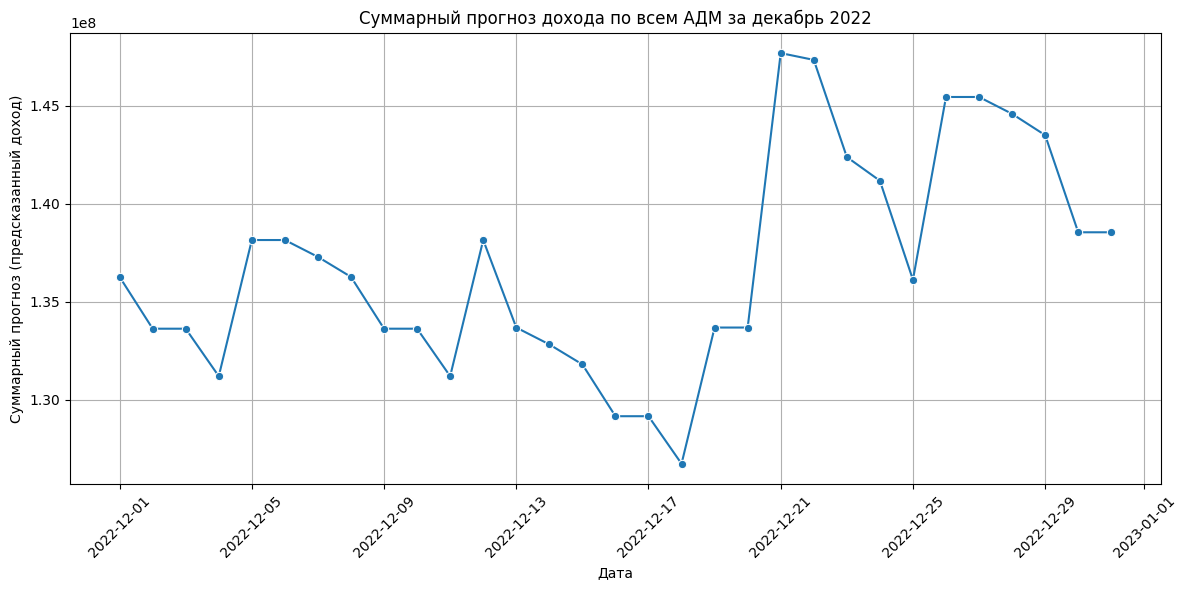

In [12]:
# Суммарный прогноз по дате (всего по всем АДМ)
daily_sum = result_december.groupby('date')['predicted_income'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_sum, x='date', y='predicted_income', marker='o')
plt.title('Суммарный прогноз дохода по всем АДМ за декабрь 2022')
plt.xlabel('Дата')
plt.ylabel('Суммарный прогноз (предсказанный доход)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

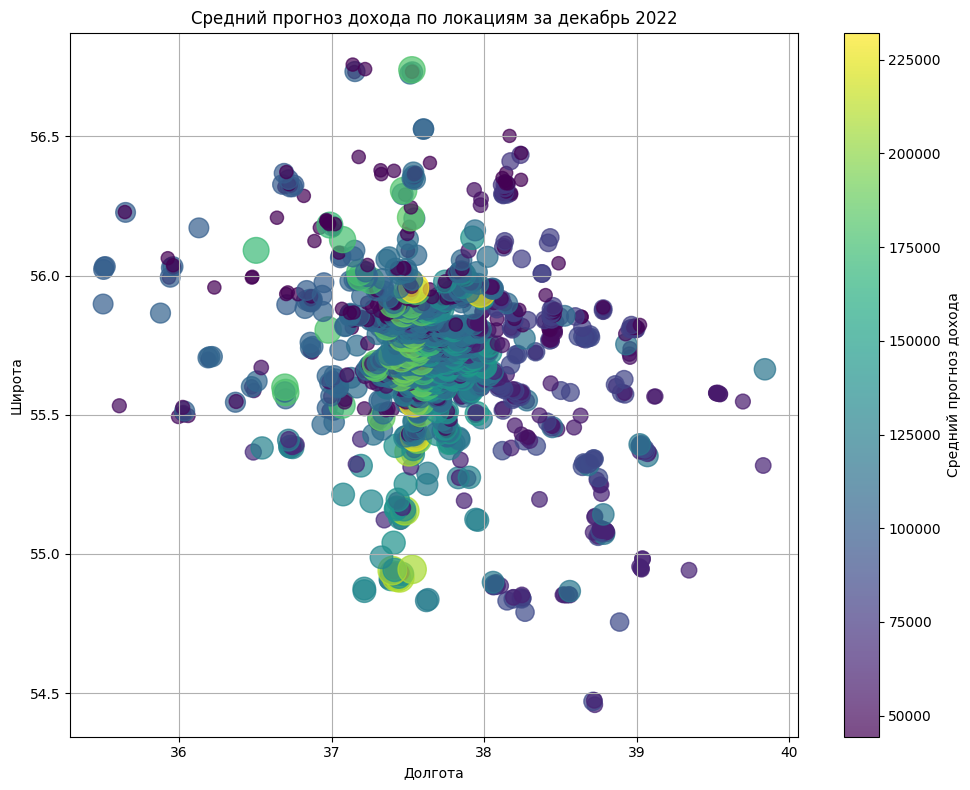

In [13]:
# Средний прогноз по каждой локации за декабрь

location_avg = result_december.groupby(['latitude', 'longitude'])['predicted_income'].mean().reset_index()

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    location_avg['longitude'],
    location_avg['latitude'],
    c=location_avg['predicted_income'],
    s=location_avg['predicted_income'] / 500,  # подгоняем размер
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(sc, label='Средний прогноз дохода')
plt.title('Средний прогноз дохода по локациям за декабрь 2022')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.grid(True)
plt.tight_layout()
plt.show()

# Заключение

**1. Анализ и предобработка данных**
- Объединение исторических данных за сентябрь-ноябрь 2022
- Очистка данных: проверка на пропуски, аномалии и согласованность
- Верификация координат АДМ и временных меток

**2. Построение признакового пространства**
- Временные признаки: день недели, номер дня, дни до конца месяца
- Лаговые признаки (1, 3, 7 дней) и скользящие средние (3, 7, 14 дней)
- Кластеризация АДМ по паттернам внесений

**3. Моделирование**
- Использована модель LightGBM (градиентный бустинг)
- Обучение без утечек данных
- Валидация на исторических периодах

**4. Прогнозирование**
- Подготовка декабрьского датасета
- Генерация признаков для прогнозного периода
- Построение предсказаний по дням для всех АДМ

**Результаты**
- Получены прогнозные значения на декабрь 2022
- АДМ кластеризирвоаны
- Модель показала адекватное качество
- Признаки интерпретированы. Указаны точки роста